# Amazon Baby Products Rating Analysis

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# preprocessing with tokenisation, stopword removal, polarity
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk import WordNetLemmatizer

In [58]:
# Division of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [4]:
# visualisation with ngrams, wordcloud
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud

In [5]:
# feature engineering 
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [6]:
# Model training and validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier # Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [7]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [8]:
# Read data from local directory
df = pd.read_csv('amazon_baby.csv')

In [9]:
df.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183531 entries, 0 to 183530
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    183213 non-null  object
 1   review  182702 non-null  object
 2   rating  183531 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


## 1. Handling missing values

In [11]:
# check the missing values
print("Shape of the dataset: ", df.shape)
print(df.isnull().sum())

Shape of the dataset:  (183531, 3)
name      318
review    829
rating      0
dtype: int64


In [12]:
df = df.dropna()

In [13]:
df.shape

(182384, 3)

In [14]:
df['rating'].value_counts()

5    106265
4     33053
3     16705
1     15100
2     11261
Name: rating, dtype: int64

## 2. Data Exploration

Text(0.5, 1.0, 'Total reviews for each rating after cleaning')

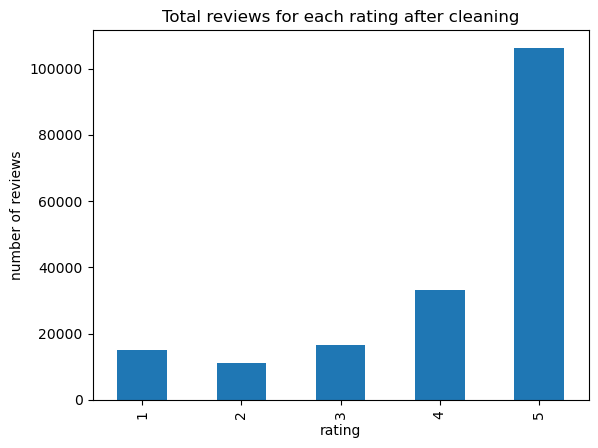

In [15]:
df.groupby(by='rating').review.count().plot.bar()
plt.xlabel('rating')
plt.ylabel('number of reviews')
plt.title('Total reviews for each rating after cleaning')

It is observed that we have an unbalanced dataset. The rating of 5 have significant larger amount of data than other ratings.  To solve this, we could use some techniques like SMOTE or oversampling the data.

## 3. Splitting data 

The data is divided into three parts, train, test and validation. THe train dataset will be used to fit the model. The test dataset will be used to choose the best model and the validation dataset will be used to estimate the errors.

In [16]:
# Divide the data in train and test sets in 80:20
X_train, X_test, y_train, y_test = train_test_split(df, df['rating'], test_size=0.20, random_state=6854)

# Further divide the test dataset in test and validation sets in 70:30
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.30, random_state=9584)

In [17]:
print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Validation data shape: {X_validation.shape}')

Train data shape: (145907, 3)
Test data shape: (25533, 3)
Validation data shape: (10944, 3)


## 4. Preprocessing text data

### 4.1 Expanding the contractions

A computer does not recognise that the contractions are abbreviations for a combination of words. Therefore, we have to clean the data by expanding the contractions such that the computer could know the meaning of the sentences.

In [18]:
# create a map for contraction to expansion
contraction_map = {
"a'ight":"alright",
"ain't":"are not",
"amn't":"am not",
"aren't":"are not",
"can't":"cannot",
"'cause": "because",
"could've":"could have",
"couldn't":"could not",
"couldn't've":"could not have",
"daren't":"dare not",
"daresn't":"dare not",
"dasn't":"dare not",
"didn't":"did not",
"doesn't":"does not",
"don't":"do not",
"everybody's":"everybody is",
"everyone's":"everyone is",
"giv'n":"given",
"gonna":"going to",
"gon't":"go not", 
"gotta":"got to",
"hadn't":"had not",
"had've":"had have",
"hasn't":"has not",
"haven't":"have not",
"he'd":"he had", 
"he'll":"he will",
"he's":"he is",
"here's":"here is",
"how'd":"how did",
"how'll":"how will",
"how're":"how are",
"how's":"how is",
"I'd":"I had",
"I'd've":"I would have",
"I'd'nt":"I would not",
"I'd'nt've":"I would not have",
"I'll":"I will",
"I'm":"I am",
"I've":"I have",
"isn't":"is not",
"it'd":"it would",
"it'll":"it will",
"it's":"it is",
"let's":"let us",
"ma'am":"madam",
"mayn't":"may not",
"may've":"may have",
"mightn't":"might not",
"might've":"might have",
"mustn't":"must not",
"mustn't've":"must not have",
"must've":"must have",
"needn't":"need not",
"needn't've":"need not have",
"o'clock":"of the clock",
"oughtn't":"ought not",
"oughtn't've":"ought not have",
"shan't":"shall not",
"she'd":"she would",
"she'll":"she will",
"she's":"she is",
"should've":"should have",
"shouldn't":"should not",
"shouldn't've":"should not have",
"somebody's":"somebody is",
"someone's":"someone is",
"something's":"something is",
"so're":"so are",
"so’s":"so is",
"so’ve":"so have",
"that'll":"that will",
"that're":"that are",
"that's":"that is",
"that'd":"that would",
"there'd":"there would",
"there'll":"there will",
"there're":"there are",
"there's":"there is",
"these're":"these are",
"these've":"these have",
"they'd":"they would",
"they'll":"they will",
"they're":"they are",
"they've":"they have",
"this's":"this is",
"those're":"those are",
"those've":"those have",
"to've":"to have",
"wasn't":"was not",
"we'd":"we would",
"we'd've":"we would have",
"we'll":"we will",
"we're":"we are",
"we've":"we have",
"weren't":"were not",
"what'd":"what did",
"what'll":"what will",
"what're":"what are",
"what's":"what is",
"what've":"what have",
"when's":"when is",
"where'd":"where did",
"where'll":"where will",
"where're":"where are",
"where's":"where is",
"where've":"where have",
"which'd":"which would",
"which'll":"which will",
"which're":"which are",
"which's":"which is",
"which've":"which have",
"who'd":"who would",
"who'd've":"who would have",
"who'll":"who will",
"who're":"who are",
"who's":"who is",
"who've":"who have",
"why'd":"why did",
"why're":"why are",
"why's":"why is",
"won't":"will not",
"would've":"would have",
"wouldn't":"would not",
"wouldn't've":"would not have",
"y'at":"you at",
"yes’m":"yes madam",
"you'd":"you would",
"you'll":"you will",
"you're":"you are",
"you've":"you have"}

In [19]:
# function to expand contraction
def exp_cont(review):
    convertedreview = ""
    for word in review.split():
        if word in contraction_map:
            convertedreview += contraction_map[word] + " "
        else:
            convertedreview += word + " "
    return convertedreview[:-1]
    

            

In [20]:
# apply the expand contraction function on train dataset
X_train['review'] = X_train['review'].apply(exp_cont)

### 4.2 Tokenisation

It is a process to split a sentence, phrase or paragraph into smaller units. Each of these smaller parts are called tokens. The punctuation would be removed through the process.

In [21]:
# function to tokenise the review
def tokenisation(review):
    # remove web link
    review = re.sub(r'www','https',review)
    review = re.sub(r'http[^\s]+','',review)
    review = re.sub('@[^\s]+','',review)
    tokenizer = RegexpTokenizer("[a-zA-Z]+", discard_empty=True)
    review = tokenizer.tokenize(review)
    review = " ".join(review)
    return review.lower()
    


In [22]:
# apply tokenisation function on train dataset
X_train['review'] = X_train['review'].apply(tokenisation)

### 4.3 Remove stopwords

Stopwords do not have valuable information for the analysis. It is better to remove them from the data. Example of stopwords such as 'the', 'a' and so on. They are common occuring words.

In [23]:
# function to remove stopwords
def stopwords_removal(review):
    # stopwords from library
    remove_word = stopwords.words('english')
    # retain the stopword 'not' and 'no'
    remove_word.remove('not')
    remove_word.remove('no')
    convertedreview = ""
    for word in review.split():
        if word not in remove_word:
            convertedreview += word + " "
        
    return convertedreview[:-1]
    


In [24]:
# apply stopwords removal function on train dataset
X_train['review'] = X_train['review'].apply(stopwords_removal)

### 4.4 Lemmatisation

It is the process of using a single term to describe a group of different words that have similar meanings. This process could reduce the complexity of analysis.

In [25]:
# function to lemmatise the review

def lemmatisation(review):
    lemmatiser = WordNetLemmatizer()
    convertedreview = ""
    for word in review.split():
        convertedreview += lemmatiser.lemmatize(word) + " "
    return convertedreview[:-1]
        


In [26]:
X_train['review'] = X_train['review'].apply(lemmatisation)    

Data preprocessing is completed.

## 5. Data Visualisation

Visualising data help us to understand the data in order to add more features.

In [27]:
# polarity column
X_train['polarity'] = X_train['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# review length column
X_train['review_len'] = X_train['review'].apply(lambda x:len(x))

# word count column
X_train['word_count'] = X_train['review'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Sentiment Polarity Distribution')

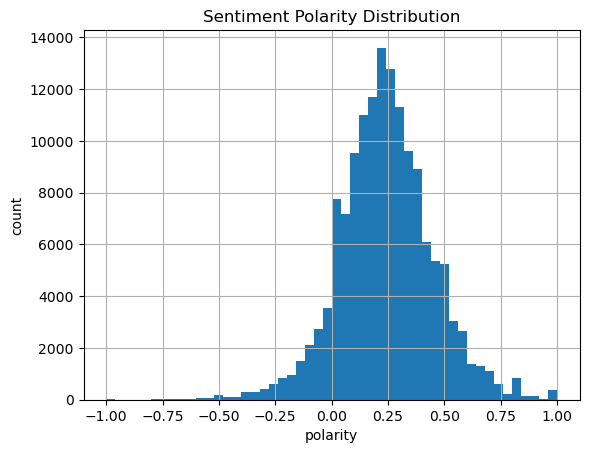

In [28]:
# histogram for polarity
X_train['polarity'].hist(bins=50)
plt.xlabel('polarity')
plt.ylabel('count')
plt.title('Sentiment Polarity Distribution')

Text(0.5, 1.0, 'Word Count Distribution')

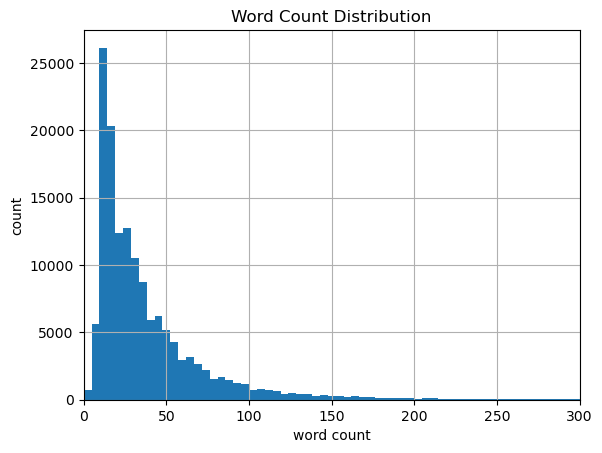

In [29]:
X_train['word_count'].hist(bins=300)
plt.xlabel('word count')
plt.ylabel('count')
plt.xlim(0, 300)
plt.title('Word Count Distribution')

Text(0.5, 1.0, 'Review Text Length Distribution')

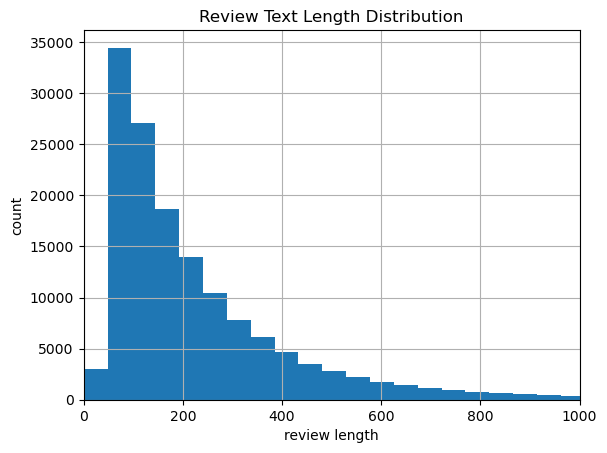

In [30]:
X_train['review_len'].hist(bins=200)
plt.xlabel('review length')
plt.ylabel('count')
plt.xlim(0, 1000)
plt.title('Review Text Length Distribution')

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145907 entries, 156272 to 6533
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   name        145907 non-null  object 
 1   review      145907 non-null  object 
 2   rating      145907 non-null  int64  
 3   polarity    145907 non-null  float64
 4   review_len  145907 non-null  int64  
 5   word_count  145907 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.8+ MB


Text(0.5, 1.0, 'No. of charcter vs Rating')

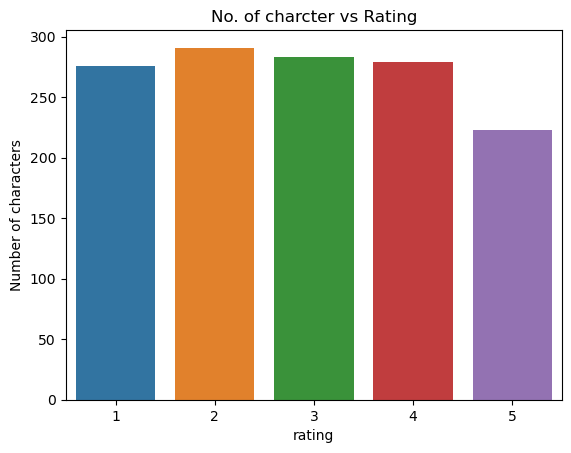

In [32]:
sns.barplot(x='rating', y='review_len', data=X_train, errorbar=None)
plt.xlabel('rating')
plt.ylabel('Number of characters')
plt.title('No. of charcter vs Rating')

In [33]:
X_trainNegReviews = X_train[X_train["rating"] < 3]
X_trainPosReviews = X_train[X_train["rating"] > 3]

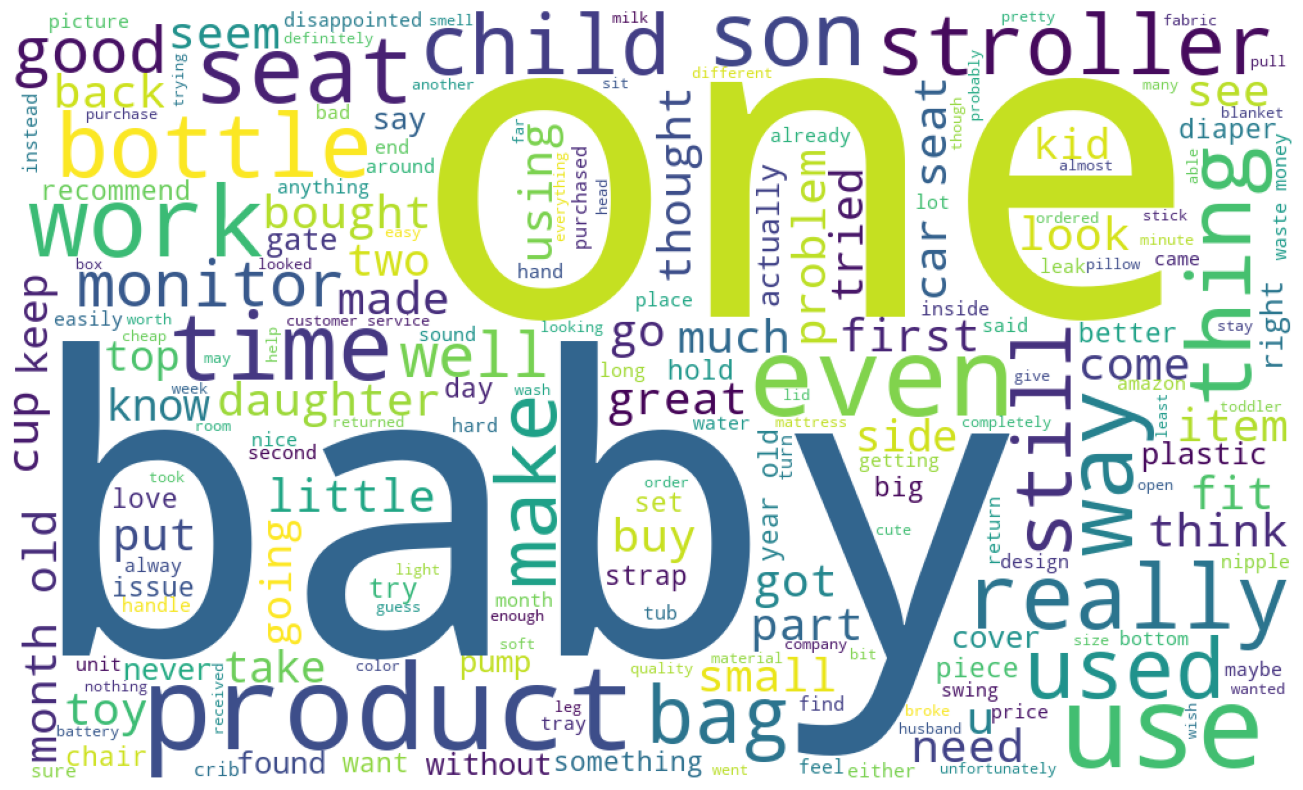

In [34]:
# wordcloud of negative review
negcloud = ""
for review in X_trainNegReviews['review']:
    negcloud += review
        
wordcloud = WordCloud(background_color="white",width=1000, height=600).generate(negcloud)
plt.figure( figsize=(20,10))
plt.axis('off')
plt.imshow(wordcloud)

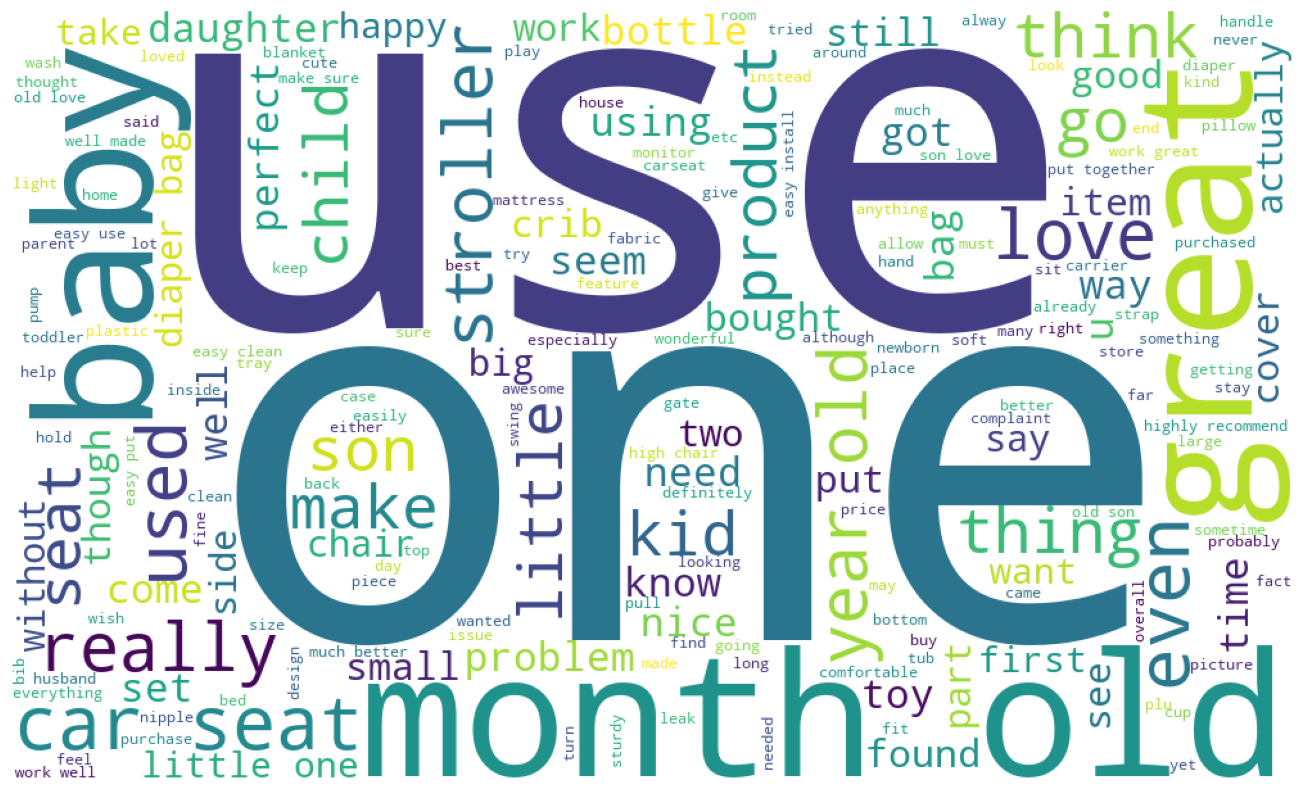

In [35]:
# wordcloud for positive review
poscloud = ""
for review in X_trainPosReviews['review']:
    poscloud += review
        
wordcloud = WordCloud(background_color="white",width=1000, height=600).generate(poscloud)
plt.figure( figsize=(20,10))
plt.axis('off')
plt.imshow(wordcloud)

In [36]:
def generateNgrams(reviews, nsize):
    ''' 
    reviews: dataframe of reviews only
    n size: size of ngram such as 1,2,3..
    
    Output:
    dataframe:{columns = {'words','count'}}
    '''
    
    
    ngrams_all = []
    
    for review in reviews:
        
        # split the review
        review = review.split()
        
        if len(review) >= nsize:
            
            # NLTK's ngrams function
            output = list(ngrams(review, nsize))             
        else:
            continue
            
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
            
    count_ngram = Counter()
    
    
    # making word frequency dictionary
    for word in ngrams_all:  
        count_ngram[word] += 1
        
    
    # converting from dictionary to dataframe data structure
    
    df = pd.DataFrame.from_dict(count_ngram, orient='index').reset_index()
    
    df = df.rename(columns={'index':'words', 0:'count'})
    
    # highest freq words on the top
    df = df.sort_values(by='count', ascending=False) 
    
    # taking 20 most frequent n-grams
    df = df.head(20)
    
    df = df.sort_values(by='count')
    
    
    return df

In [37]:
def plotNgrams(reviews):
    
    unigrams = generateNgrams(reviews, 1)
    bigrams = generateNgrams(reviews, 2)
    trigrams = generateNgrams(reviews, 3)
    
    # Set plot figure size
    fig = plt.figure(figsize = (20, 7))
    plt.subplots_adjust(wspace=.5)
    
    # plot 1
    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=1)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')
    
    # plot 2
    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=1, color = 'red')
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')
    
    # plot 3
    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=1, color = 'green')
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

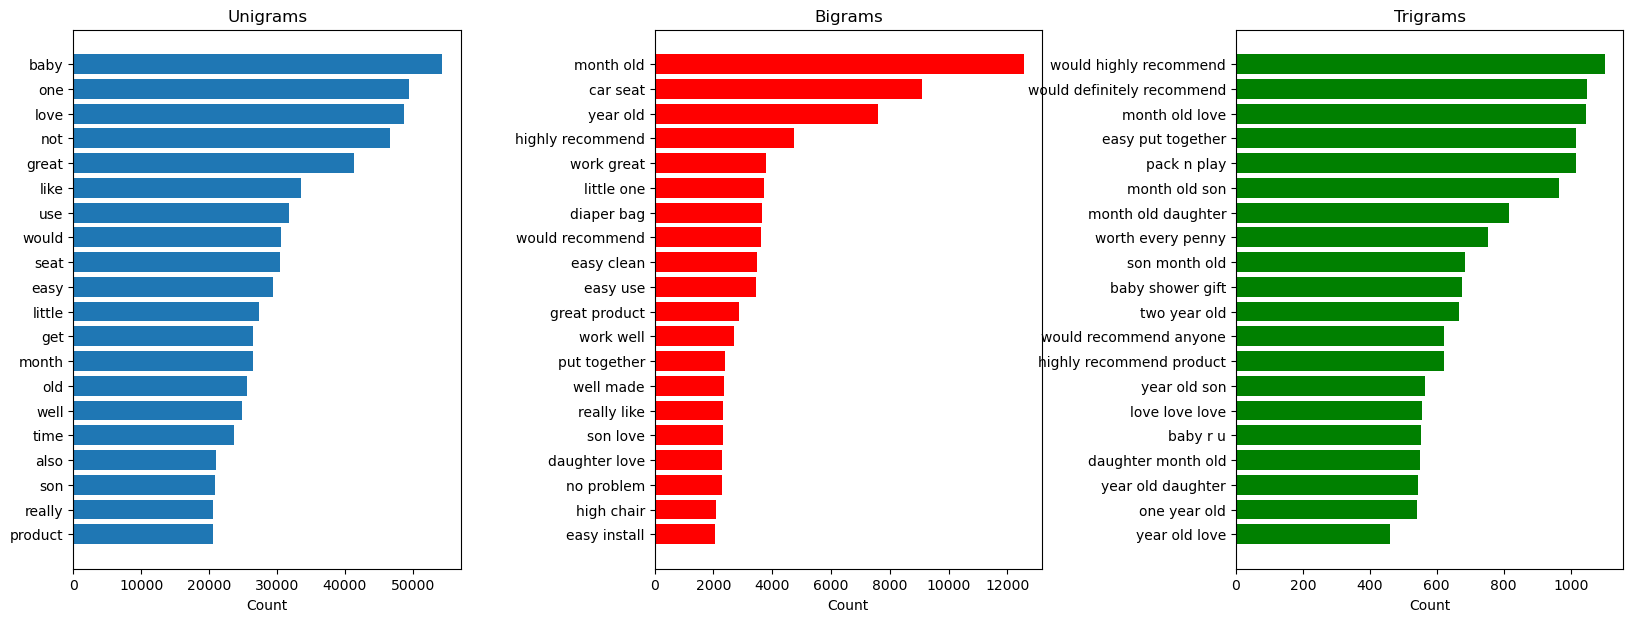

In [38]:
plotNgrams(X_trainPosReviews['review'])

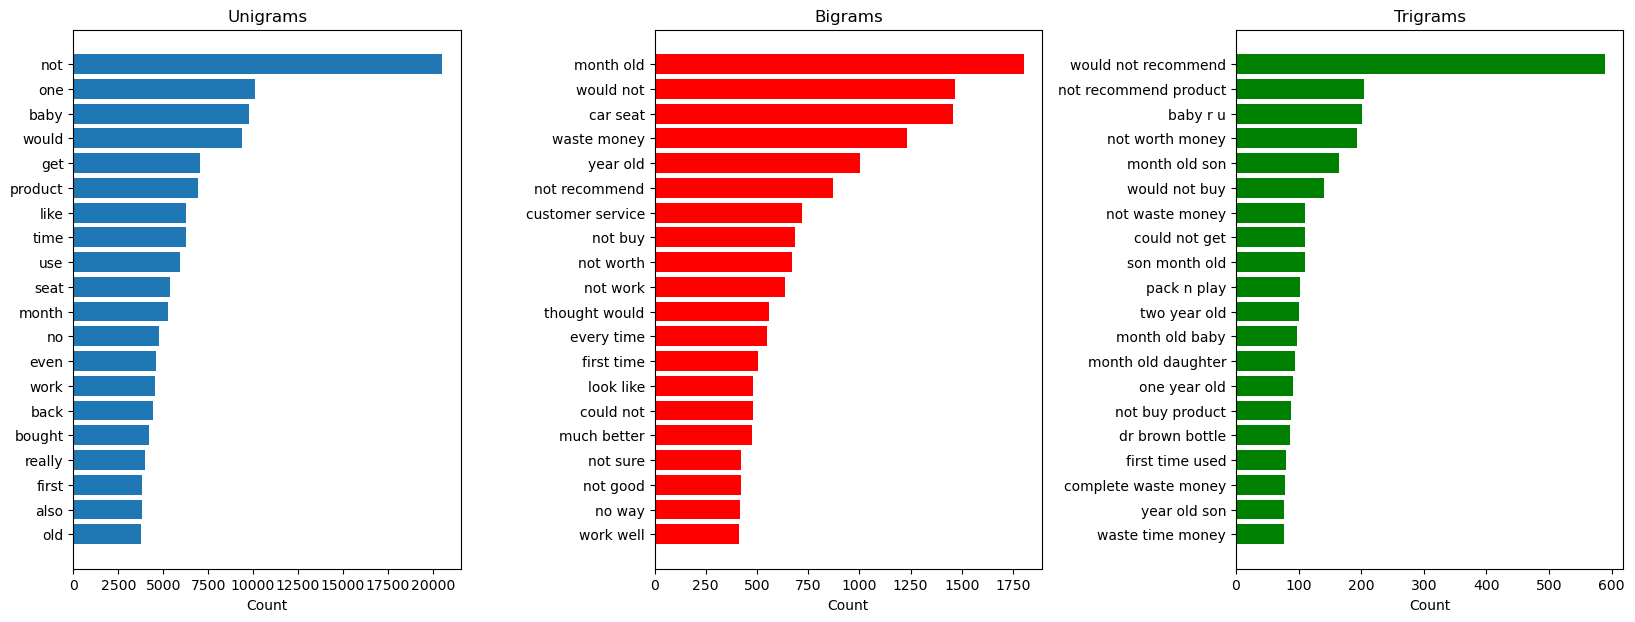

In [39]:
plotNgrams(X_trainNegReviews['review'])

## 6. Generate feature vector

Identifying the word counts and convert them to feature vectors

In [40]:
fdist = FreqDist(X_train['review'])

In [41]:
featured_words = [freq[0] for freq in list(fdist.most_common(5000))]

In [42]:
#convert the text into a matrix that contains the word count.
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(featured_words)])

In [43]:
#  normalised the matrix with TfidTransformer
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [44]:
#form the training features
ctr_features = vec.transform(X_train['review'])
tr_features = tf_vec.transform(ctr_features)

In [45]:
tr_features.shape

(145907, 10590)

## 7. Model training

In [46]:
## Apply same data preprocessing to test dataset
X_test['review'] = X_test['review'].apply(exp_cont)
X_test['review'] = X_test['review'].apply(tokenisation)
X_test['review'] = X_test['review'].apply(stopwords_removal)
X_test['review'] = X_test['review'].apply(lemmatisation)  

In [47]:
cte_features = vec.transform(X_test['review'])
te_features = tf_vec.transform(cte_features)

In [48]:
te_features.shape


(25533, 10590)

Compare between 5 models and choose the model which give the best scores

In [49]:
models = {
    'Naive_Bayes': MultinomialNB(),
    'Random_Forest':RandomForestClassifier(n_estimators = 10),
    'Decision_Tree': DecisionTreeClassifier(max_depth= 10),
    'AdaBoost':AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10)),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=10),
}

In [50]:
weighted_avg_f = {}
for name, model in models.items():
    model.fit(tr_features, y_train)

    y_predict = model.predict(te_features)
    weighted_avg_f[name] = classification_report(y_true=y_test, y_pred=y_predict,output_dict=True)['weighted avg']['f1-score']
    print('-' * 64)
    print(f'Algorithm: {name}')
    print(f'''Metrics Report: 
    {classification_report(y_true=y_test, y_pred=y_predict)}''')

----------------------------------------------------------------
Algorithm: Naive_Bayes
Metrics Report: 
                  precision    recall  f1-score   support

           1       0.68      0.22      0.34      2096
           2       0.00      0.00      0.00      1623
           3       0.28      0.00      0.01      2334
           4       0.42      0.04      0.07      4525
           5       0.61      0.99      0.76     14955

    accuracy                           0.61     25533
   macro avg       0.40      0.25      0.23     25533
weighted avg       0.51      0.61      0.48     25533

----------------------------------------------------------------
Algorithm: Random_Forest
Metrics Report: 
                  precision    recall  f1-score   support

           1       0.49      0.40      0.44      2096
           2       0.21      0.05      0.08      1623
           3       0.28      0.10      0.15      2334
           4       0.37      0.19      0.25      4525
           5       0

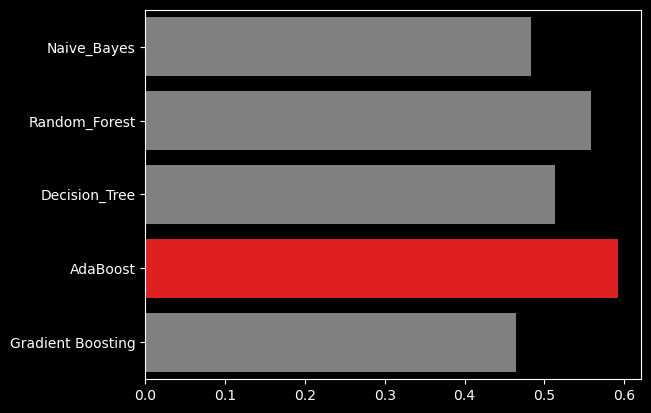

In [51]:
# Use red for bar with max value and grey for all other bars
cols = ['grey' if (x < max(list(weighted_avg_f.values()))) else 'red' for x in list(weighted_avg_f.values())]

plt.style.use('dark_background')
sns.barplot(x=list(weighted_avg_f.values()), y=list(weighted_avg_f.keys()),
           palette=cols)
plt.show()

## 8. Hyperparameter tuning

AdaBoost gives the best scores. Next we have to tune the hyperparameters.

In [52]:
hyperparameters = {
    'n_estimators' : [10, 20, 50],
    'learning_rate' : [0.9, 1.0]
}

In [53]:
%%time
randomised_search = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10)),
                       param_grid=hyperparameters, scoring='f1_weighted', cv=5, n_jobs =-1)
randomised_search.fit(tr_features, y_train)


CPU times: total: 5min 18s
Wall time: 1h 22min 16s


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.9, 1.0],
                         'n_estimators': [10, 20, 50]},
             scoring='f1_weighted')

In [54]:
# print out the best parameters and score
print("Best parameters: ", randomised_search.best_params_)
print("Best score: ", randomised_search.best_score_)

Best parameters:  {'learning_rate': 0.9, 'n_estimators': 20}
Best score:  0.5910320800380751


## 9. Result

Use validation dataset for the final estimation of error.

In [55]:
## Apply same data preprocessing to validation dataset
X_validation['review'] = X_validation['review'].apply(exp_cont)
X_validation['review'] = X_validation['review'].apply(tokenisation)
X_validation['review'] = X_validation['review'].apply(stopwords_removal)
X_validation['review'] = X_validation['review'].apply(lemmatisation)  

In [56]:
cva_features = vec.transform(X_validation['review'])
va_features = tf_vec.transform(cva_features)

In [60]:
final_result = cross_validate(randomised_search.best_estimator_,tr_features,y_train,cv=5,scoring='f1_weighted')

In [62]:
print(f'Final score on train set: {np.mean(final_result["test_score"])}')
print(f'Final score on validation set: {randomised_search.score(va_features,y_validation)}')

Final score on train set: 0.590442350392349
Final score on validation set: 0.6020894430309003


## 10. Result Improvement

1. Use SMOTE technique, oversampling or undersampling to deal with the imbalanced data

1. Predict  positive/negative review instead of 5 star rating

1. Perform spell checking to ensure all the words are correct in the reviews

1. Try other models such as Artificial Neural Network and Xgboosting (time consuming)

1. Use bigram and Trigram for feature vectors generation (resources needed)